In [1]:
from signal_utils import *

## Config Data

In [2]:
# Test signal
N = 1024
F = 50/N

perc = 0.15
Fmax = 0.5 * (1 - perc)
print(f"Fmax = {Fmax}")

# Serialization
LUTs = [LUT1, LUT2, LUT3, LUT4, LUT5]
lut_width = np.array([len(LUT[0]) for LUT in LUTs])

# Interpolation
OSR = 8
AdB_interpolation = 100

# Delay
delay_order = 3
i_delay_factor = 1/8
q_delay_factor = -1/8
i_delay_delta = 1/lut_width * (1/OSR) * i_delay_factor
q_delay_delta = 1/lut_width * (1/OSR) * q_delay_factor

Fmax = 0.425


## Test Signal

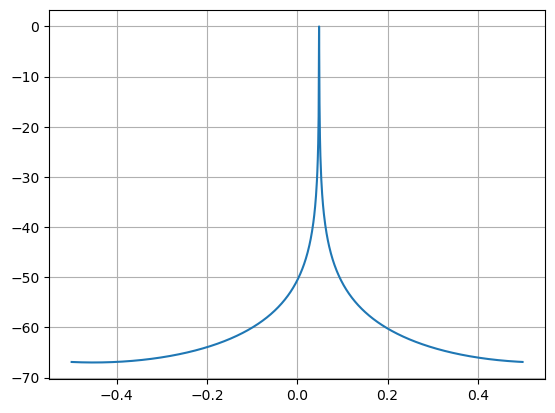

In [3]:
x_test = 1.0 * np.exp(1j * 2*np.pi*F*np.arange(N+delay_order))
xi_test = x_test.real
xq_test = x_test.imag

plotdB(x_test, win=False)

## Delay

In [4]:
xi_delay = []
xq_delay = []

xi_ideal_delay = []
xq_ideal_delay = []

error_i = []
error_q = []

for i_delta, q_delta in zip(i_delay_delta, q_delay_delta):
    xi_delay_tmp = delay_taylor(xi_test, i_delta, delay_order)
    xq_delay_tmp = delay_taylor(xq_test, q_delta, delay_order)
    xi_delay.append(xi_delay_tmp)
    xq_delay.append(xq_delay_tmp)

    xi_ideal_delay_tmp = (1.0 * np.exp(1j * 2*np.pi*F*(np.arange(N+delay_order//2) - i_delta))).real
    xq_ideal_delay_tmp = (1.0 * np.exp(1j * 2*np.pi*F*(np.arange(N+delay_order//2) - q_delta))).imag

    error_i.append(np.abs(xi_delay_tmp[delay_order//2:-delay_order//2]-xi_ideal_delay_tmp[delay_order//2:]))
    error_q.append(np.abs(xq_delay_tmp[delay_order//2:-delay_order//2]-xq_ideal_delay_tmp[delay_order//2:]))

print(error_i)
print('')
print(error_q)

plt.figure()
plt.title("I Delay Error")
for e_i in error_i:
    plt.plot(e_i)
plt.show();

plt.figure()
plt.title("Q Delay Error")
for e_q in error_q:
    plt.plot(e_q)
plt.show();

NameError: name 'delay_taylor' is not defined

## Interpolation

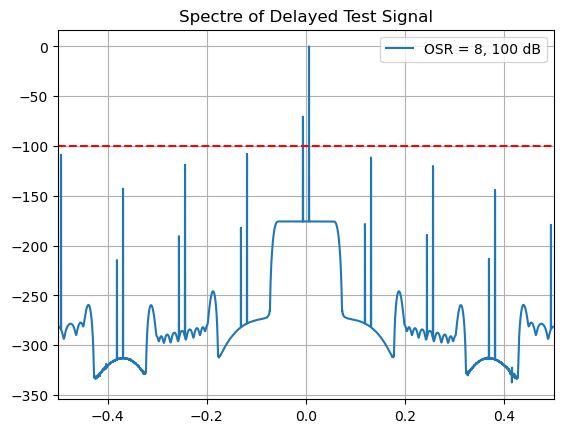

In [5]:
deltaPass = 10**(-AdB_interpolation/20)
deltaStop = deltaPass

F_interpolation = [Fmax, 1-Fmax]
delta = [deltaPass, deltaStop]

# Interpolation by a factor of 8
xi_osr = []
xq_osr = []
x_osr = []
for xi, xq in zip(xi_delay, xq_delay):
    xi_osr_tmp = np.real(interpolate(xi[delay_order//2:-delay_order//2], OSR, F_interpolation, delta, show=False, prt=False))
    xq_osr_tmp = np.real(interpolate(xq[delay_order//2:-delay_order//2], OSR, F_interpolation, delta, show=False, prt=False))
    xi_osr.append(xi_osr_tmp)
    xq_osr.append(xq_osr_tmp)
    x_osr.append(xi_osr_tmp + 1j*xq_osr_tmp)

freqs_osr, xfftdB_osr, angle_osr = fftdB(x_osr[0])
xmin = -0.5
xmax = 0.5
plt.title("Spectre of Delayed Test Signal")
plt.plot(freqs_osr, xfftdB_osr, label=f"OSR = {OSR}, {AdB_interpolation} dB")
plt.plot([xmin, xmax], [-AdB_interpolation, -AdB_interpolation], '--r')
plt.legend()
plt.xlim([xmin, xmax])
plt.grid()
plt.show();

## Delta-Sigma Modulation (from cpp)

In [6]:
# quant_type = "mid-tread"

# Path to C++ executable
cpp_path = "../build/delta-sigma"
xi_in_path = "./data/serial/xr_in.txt"
xq_in_path = "./data/serial/xi_in.txt"
xi_out_path = "./data/serial/xr_out.txt"
xq_out_path = "./data/serial/xi_out.txt"
iir_path = "../data/input/deltaSigma_iirs.txt"

In [7]:
quant_type = ["mid-tread", "mid-tread", "mid-tread", "mid-rise", "mid-rise"]
xi_deltaSigma = []
xq_deltaSigma = []
x_deltaSigma = []

for xi, xq, quant_i in zip(xi_osr, xq_osr, quant_type):
    tmp = 4/np.max(xi)
    xi_input = np.array(xi) * tmp
    xq_input = np.array(xq) * tmp
    
    np.savetxt(xi_in_path, xi_input, fmt="%.18e")
    np.savetxt(xq_in_path, xq_input, fmt="%.18e")
    
    # Call the C++ program with input and output file paths as arguments
    subprocess.run([cpp_path, xi_in_path, xq_in_path, xi_out_path, xq_out_path, iir_path, quant_i])
    
    xi_deltaSigma_tmp = np.round(np.loadtxt(xi_out_path))
    xq_deltaSigma_tmp = np.round(np.loadtxt(xq_out_path))
    x_deltaSigma_tmp = xi_deltaSigma_tmp + 1j*xq_deltaSigma_tmp

    xi_deltaSigma.append(xi_deltaSigma_tmp)
    xq_deltaSigma.append(xq_deltaSigma_tmp)
    x_deltaSigma.append(x_deltaSigma_tmp)

File written to ./data/serial/xr_out.txt
File written to ./data/serial/xi_out.txt
File written to ./data/serial/xr_out.txt
File written to ./data/serial/xi_out.txt
File written to ./data/serial/xr_out.txt
File written to ./data/serial/xi_out.txt
File written to ./data/serial/xr_out.txt
File written to ./data/serial/xi_out.txt
File written to ./data/serial/xr_out.txt
File written to ./data/serial/xi_out.txt


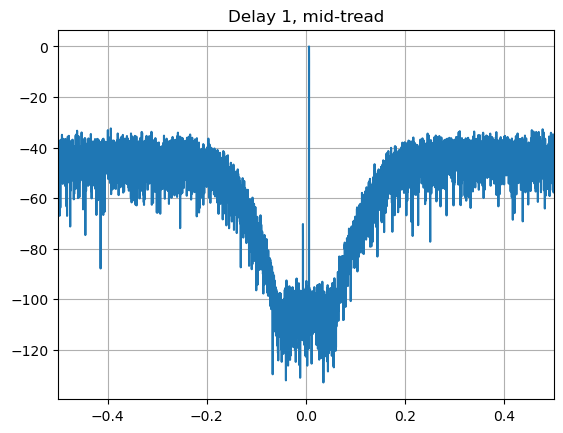

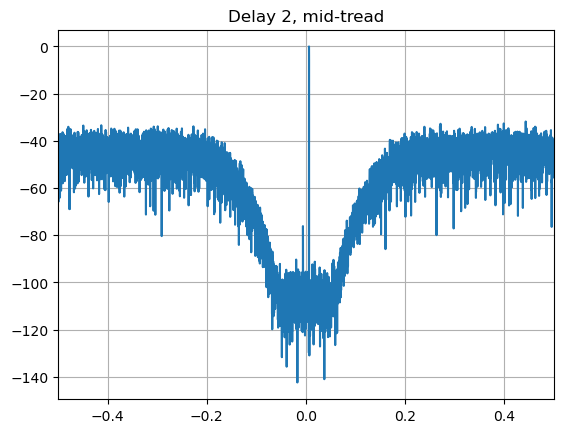

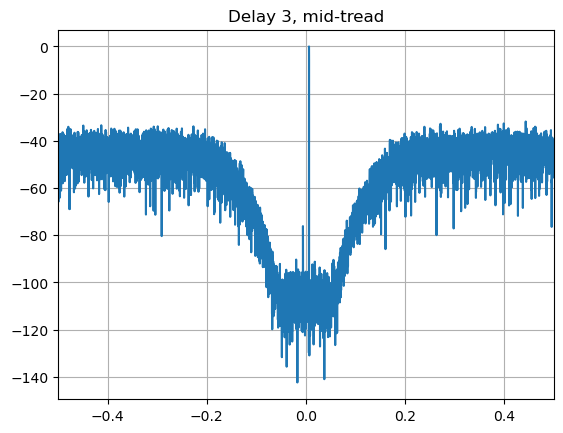

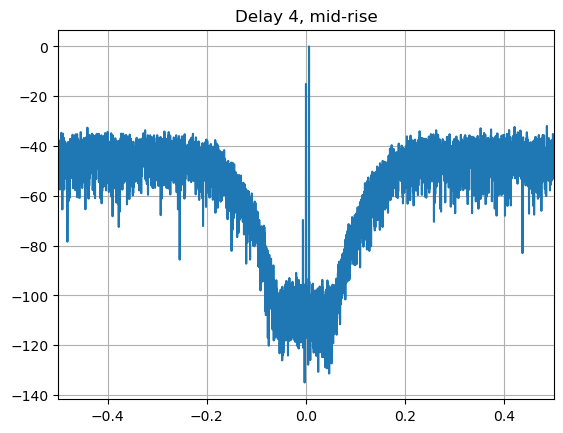

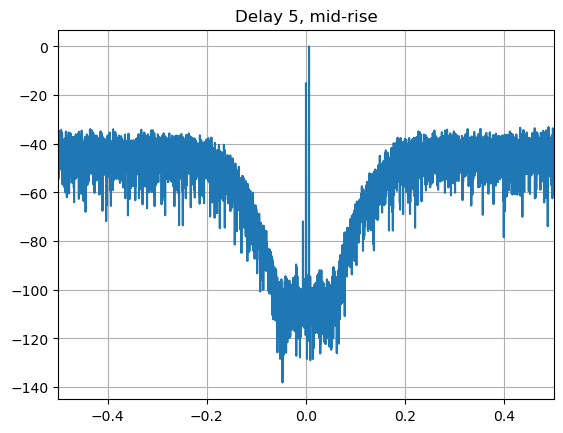

In [8]:
delay = ["Delay 1", "Delay 2", "Delay 3", "Delay 4", "Delay 5"]
for x_i,di,quant_i in zip(x_deltaSigma, delay, quant_type):
    freqs_i, xfftdB_i, angle_i = fftdB(x_i)
    xmin = -0.5
    xmax = 0.5
    plt.title(di + ", " + quant_i)
    plt.plot(freqs_i, xfftdB_i)
    plt.xlim([xmin, xmax])
    plt.grid()
    plt.show();

## Serialization (LUT)

In [9]:
LUTs = [LUT1, LUT2, LUT3, LUT4, LUT5]
quant_type = ["mid-tread", "mid-tread", "mid-tread", "mid-rise", "mid-rise"]

xi_serial = []
xq_serial = []
x_serial = []

for xi, xq, LUT, quant_i in zip(xi_deltaSigma, xq_deltaSigma, LUTs, quant_type):
        
    xi_1b = convert_1b(xi, LUT, quant_i)
    xq_1b = convert_1b(xq, LUT, quant_i)
    x_1b = xi_1b + 1j*xq_1b

    xi_serial.append(xi_1b)
    xq_serial.append(xq_1b)
    x_serial.append(x_1b)

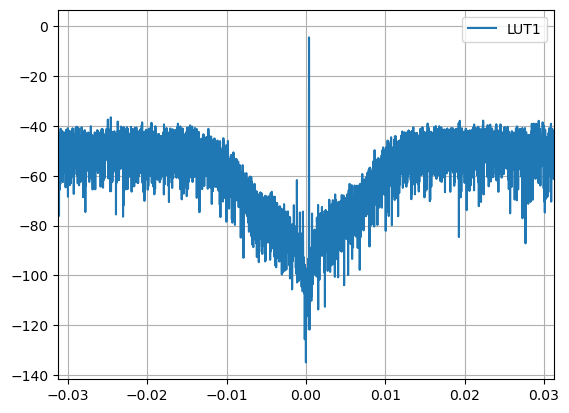

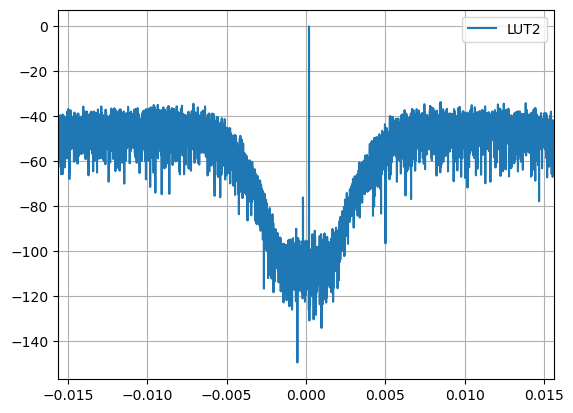

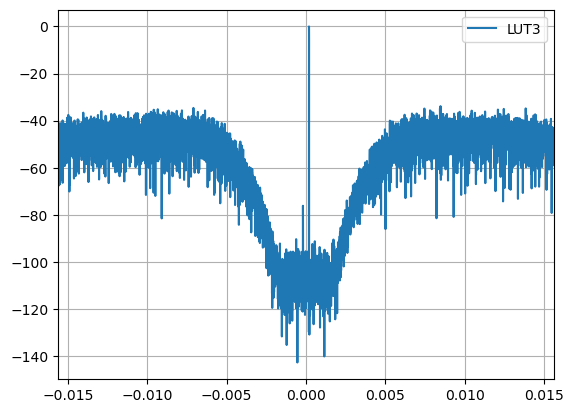

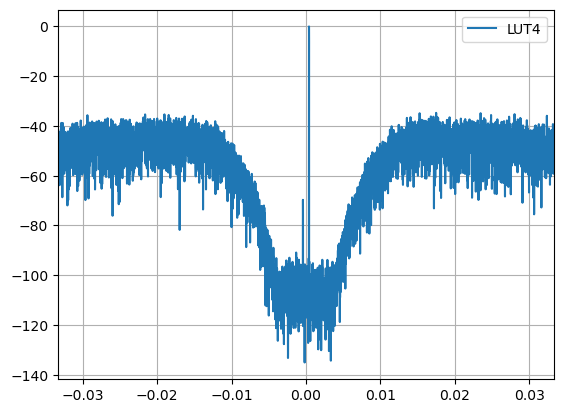

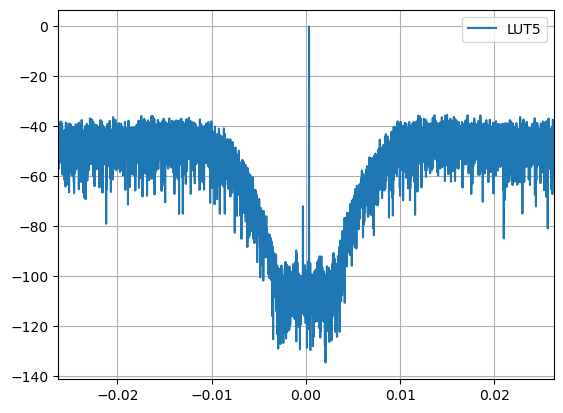

In [10]:
labels = ["LUT1", "LUT2", "LUT3", "LUT4", "LUT5"]

for x_i,LUT,label_i in zip(x_serial, LUTs, labels):
    freqs_i, xfftdB_i, angle_i = fftdB(x_i)
    xmin = -0.5/len(LUT[0])
    xmax = 0.5/len(LUT[0])
    plt.plot(freqs_i, xfftdB_i, label=label_i)
    plt.legend()
    plt.xlim([xmin, xmax])
    plt.grid()
    plt.show();

## RFIQ Serial

In [11]:
x_rfiq = []
for xrfiq_in in x_serial:
    x_rfiq.append(rfiq(xrfiq_in.real, xrfiq_in.imag))

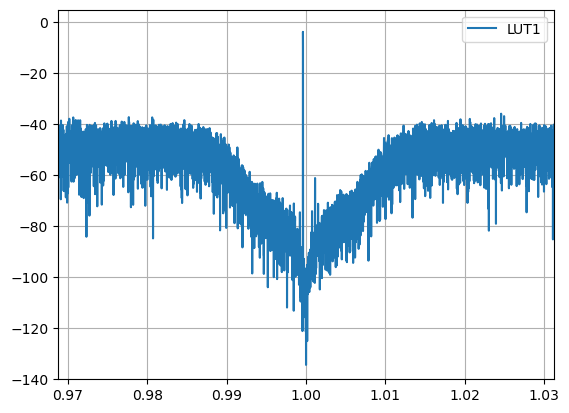

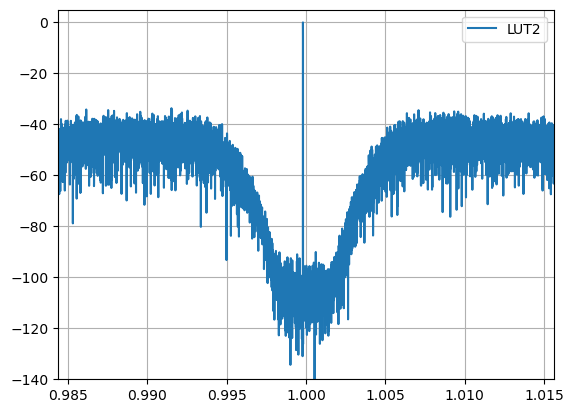

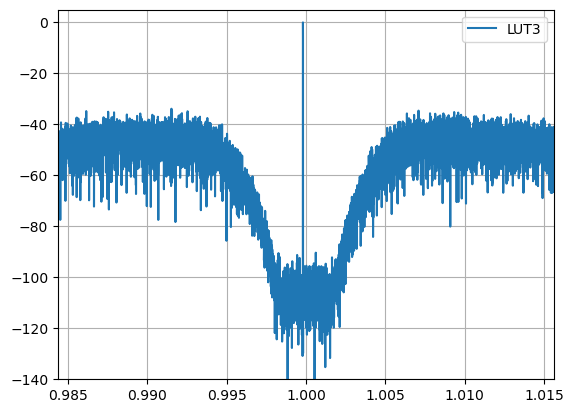

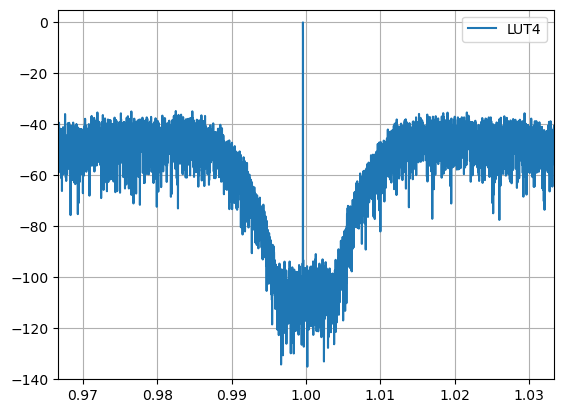

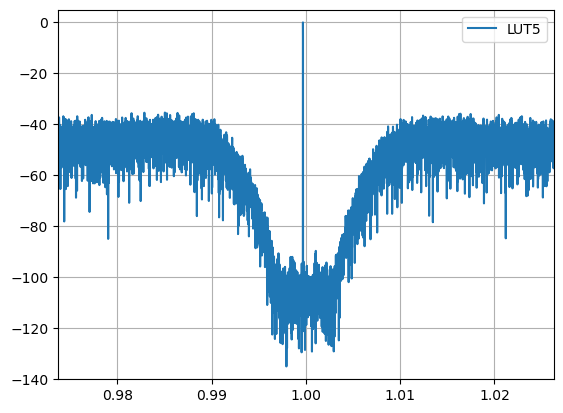

In [12]:
labels = ["LUT1", "LUT2", "LUT3", "LUT4", "LUT5"]

for x_i,LUT,label_i in zip(x_rfiq, LUTs, labels):
    freqs_i, xfftdB_i, angle_i = fftdB(x_i)
    freqs_i *= 4
    xmin = 1-0.5/len(LUT[0])
    xmax = 1+0.5/len(LUT[0])
    plt.plot(freqs_i, xfftdB_i, label=label_i)
    plt.legend()
    plt.xlim([xmin, xmax])
    plt.ylim([-140, 5])
    plt.grid()
    plt.show();

In [2]:
from dataclasses import dataclass
from typing import List, Optional

@dataclass
class RFProcessingConfig:
    delay_order: int
    i_delay_delta: float
    q_delay_delta: float
    osr: int
    AdB_osr: float
    Fmax: float
    cpp_path: str
    quant_type: str
    deltaSigmaFactor: float
    lut_n: str
    lut: List[List[int]]
    testShow: bool
    delayShow: bool
    osrShow: bool
    deltaSigmaShow: bool
    serialShow: bool
    rfiqShow: bool

In [35]:
def plotFigure(x, x_range, title="", AdB=None, freq_factor=None, y_range=None):
    freqs, xfftdB, angle = fftdB(x, win=True)
    if freq_factor:
        freqs *= freq_factor
    xmin = x_range[0]
    xmax = x_range[1]
    plt.title(title)
    plt.plot(freqs, xfftdB)
    if AdB:
        plt.plot([xmin, xmax], [-AdB, -AdB], '--r')
    plt.xlim([xmin, xmax])
    if y_range:
        plt.ylim([y_range[0], y_range[1]])
    plt.xlabel("f/fs")
    plt.ylabel("|X|dB")
    plt.grid()
    plt.show();    
    
def process(x: np.ndarray, config: RFProcessingConfig) -> np.ndarray:
    lut_width = len(config.lut[0])
    xi = x.real
    xq = x.imag

    if config.testShow:
        x_range = [-0.5, 0.5]
        plotFigure(x[config.delay_order//2:-config.delay_order//2], x_range, title=f"Test Signal", AdB=None)

    # Taylor Delay
    i_delta = 1/lut_width * 1/config.osr * config.i_delay_delta
    q_delta = 1/lut_width * 1/config.osr * config.q_delay_delta

    xi_delay = delay_taylor(xi, i_delta, config.delay_order)
    xq_delay = delay_taylor(xq, q_delta, config.delay_order)
    x_delay = xi_delay + 1j*xq_delay

    if config.delayShow:
        x_range = [-0.5, 0.5]
        plotFigure(x_delay[config.delay_order//2:-config.delay_order//2], x_range, title=f"Delayed Signal, Taylor order = {config.delay_order}", AdB=None)

    # Interpolation
    deltaPass = 10**(-config.AdB_osr/20)
    deltaStop = deltaPass
    delta_interpolation = [deltaPass, deltaStop]
    F_interpolation = [config.Fmax, 1-config.Fmax]

    xi_osr = np.real(interpolate(xi_delay[config.delay_order//2:-config.delay_order//2], config.osr, F_interpolation, delta_interpolation, show=False, prt=False))
    xq_osr = np.real(interpolate(xq_delay[config.delay_order//2:-config.delay_order//2], config.osr, F_interpolation, delta_interpolation, show=False, prt=False))
    x_osr = xi_osr + 1j*xq_osr

    if config.osrShow:
        x_range = [-0.5, 0.5]
        plotFigure(x_osr, x_range, freq_factor=1, title=f"Interpolated Signal, OSR = {osr}, AdB = {config.AdB_osr}", AdB=config.AdB_osr)

    # Delta-Sigma modulation
    xi_in_path = "./data/serial/xr_in.txt"
    xq_in_path = "./data/serial/xi_in.txt"
    xi_out_path = "./data/serial/xr_out.txt"
    xq_out_path = "./data/serial/xi_out.txt"
    iir_path = "../data/input/deltaSigma_iirs.txt"

    tmp = config.deltaSigmaFactor/np.max(xi_osr)
    xi_deltaSigma_in = np.array(xi_osr) * tmp
    xq_deltaSigma_in = np.array(xq_osr) * tmp
    
    np.savetxt(xi_in_path, xi_deltaSigma_in, fmt="%.18e")
    np.savetxt(xq_in_path, xq_deltaSigma_in, fmt="%.18e")
    
    subprocess.run([cpp_path, xi_in_path, xq_in_path, xi_out_path, xq_out_path, iir_path, config.quant_type])  # Call the C++ program with input and output file paths as arguments
    
    xi_deltaSigma = np.round(np.loadtxt(xi_out_path))
    xq_deltaSigma = np.round(np.loadtxt(xq_out_path))
    x_deltaSigma = xi_deltaSigma + 1j*xq_deltaSigma

    if config.deltaSigmaShow:
        x_range = [-0.5, 0.5]
        plotFigure(x_deltaSigma, x_range, title=f"Delta-Sigma Modulated Signal", AdB=None)

    # Serialization
    xi_1b = convert_1b(xi_deltaSigma, config.lut, config.quant_type)
    xq_1b = convert_1b(xq_deltaSigma, config.lut, config.quant_type)
    x_1b = xi_1b + 1j*xq_1b

    if config.serialShow:
        x_range = np.array([-0.5, 0.5])/lut_width
        plotFigure(x_1b, x_range, title=f"Serialized Signal, LUT = {int(config.lut_n)}", AdB=None)

    # RFIQ
    x_rfiq = rfiq(xi_1b, xq_1b)

    if config.rfiqShow:
        x_range = np.array([-0.5, 0.5])/lut_width + 1
        plotFigure(x_rfiq, x_range, title=f"Reconstructed RF Signal", AdB=None, freq_factor=4, y_range=[-130, 5])

    return x_rfiq

# def find_SNR(xdB):
#     N = len(xdB)
#     max1 = np.max(xdB[:N//2-1])
#     max2 = np.max(xdB[N//2:])
#     return [max1, max2]

def process_all(x: np.ndarray, config: RFProcessingConfig) -> np.ndarray:
    lut_width = len(config.lut[0])
    xi = x.real
    xq = x.imag

    if config.testShow:
        x_range = [-0.5, 0.5]
        plotFigure(x[config.delay_order//2:-config.delay_order//2], x_range, title=f"Test Signal", AdB=None)

    # Taylor Delay
    i_delta = 1/lut_width * 1/config.osr * config.i_delay_delta
    q_delta = 1/lut_width * 1/config.osr * config.q_delay_delta

    xi_delay = delay_taylor(xi, i_delta, config.delay_order)
    xq_delay = delay_taylor(xq, q_delta, config.delay_order)
    x_delay = xi_delay + 1j*xq_delay

    if config.delayShow:
        x_range = [-0.5, 0.5]
        plotFigure(x_delay[config.delay_order//2:-config.delay_order//2], x_range, title=f"Delayed Signal, Taylor order = {config.delay_order}", AdB=None)

    xi_delay /= np.max(xi_delay)
    xi_delay = xi_delay[config.delay_order//2:-config.delay_order//2]
    xq_delay /= np.max(xq_delay)
    xq_delay = xq_delay[config.delay_order//2:-config.delay_order//2]

    # Delta-Sigma modulation
    xi_in_path = "./data/serial/xi_in.txt"
    xq_in_path = "./data/serial/xq_in.txt"
    x_out_path = "./data/serial/x_out.txt"
    fir_path = "../data/input/polyFirCofficients_80dB.txt"
    iir_path = "../data/input/deltaSigma_iirs.txt"
    lut_path = "../data/input/LUT3.txt"

    xi_out_path = "./data/serial/xi_out.txt"
    xq_out_path = "./data/serial/xq_out.txt"
    
    np.savetxt(xi_in_path, xi_delay, fmt="%.18e")
    np.savetxt(xq_in_path, xq_delay, fmt="%.18e")

    # subprocess.run([cpp_path, xi_in_path, xq_in_path, x_out_path, fir_path, iir_path, lut_path, config.quant_type])  # Call the C++ program with input and output file paths as arguments
    subprocess.run([cpp_path, xi_in_path, xq_in_path, xi_out_path, xq_out_path, fir_path, iir_path, lut_path])  # Call the C++ program with input and output file paths as arguments

    xi_out = np.round(np.loadtxt(xi_out_path))
    xq_out = np.round(np.loadtxt(xq_out_path))
    x_out = xi_out + 1j*xq_out

    x_range = np.array([-0.5, 0.5])
    plotFigure(x_out, x_range, title=f"Reconstructed RF Signal", AdB=None)
    
    # x_rfiq = np.loadtxt(x_out_path)

    # if config.rfiqShow:
    #     x_range = np.array([-0.5, 0.5])/lut_width + 1
    #     plotFigure(x_rfiq, x_range, title=f"Reconstructed RF Signal", AdB=None, freq_factor=4, y_range=[-130, 5])
    
    return x_rfiq

def find_SNR(x, f):
    N = len(x)
    freqs, x_rfiqdB, anle = fftdB(x_rfiq)
    freqs *= 4
    f_low, f_high = f[0], f[1]
    idx_band = np.where((freqs >= f_low) & (freqs <= f_high))[0]
    return x_rfiqdB[idx_band][1]

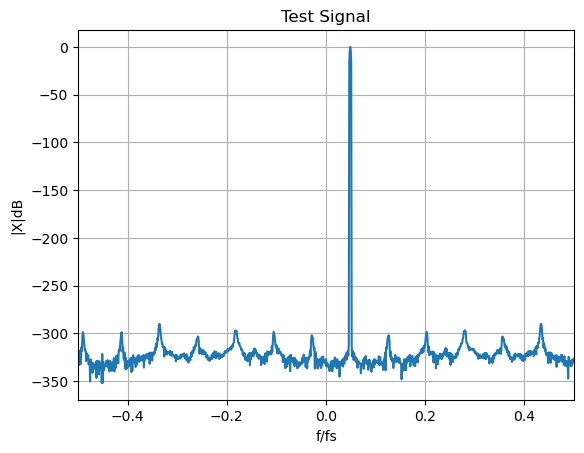

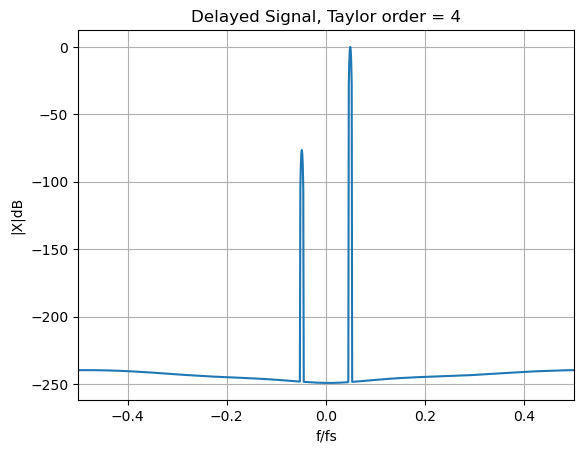

File written to ./data/serial/xi_out.txt
File written to ./data/serial/xq_out.txt


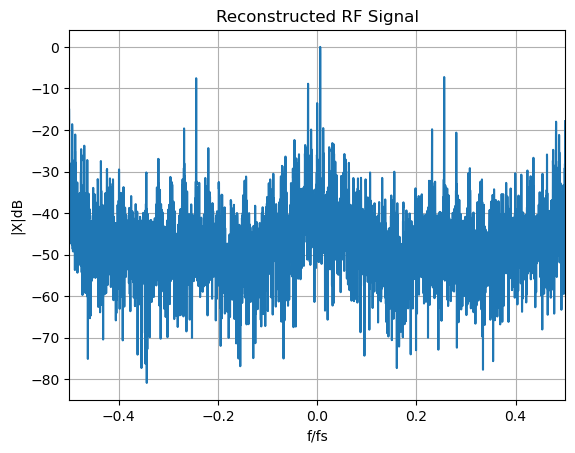

In [38]:
N = 1024
F = 50/N
perc = 0.15
Fmax = 0.5 * (1 - perc)

delay_order = 4
i_delta = 1/8
q_delta = -1/8

osr = 8
AdB_osr = 100

cpp_path = "../build/rf-process" #"../build/delta-sigma"
quant_type = 'mid-tread'

LUT_n = "3"
LUT = LUTs[int(LUT_n)-1]

x_test = 1.0 * np.exp(1j*2*np.pi*F*np.arange(N+delay_order))

config = RFProcessingConfig(
    delay_order = delay_order,
    i_delay_delta = i_delta,
    q_delay_delta = q_delta,
    osr = osr,
    AdB_osr = AdB_osr,
    Fmax = Fmax,
    cpp_path = cpp_path,
    quant_type = quant_type,
    deltaSigmaFactor = 4,
    lut_n = LUT_n,
    lut = LUT,
    testShow = True,
    delayShow = True,
    osrShow = True,
    deltaSigmaShow = True,
    serialShow = True,
    rfiqShow = True,
)

x_rfiq = process_all(x_test, config)

In [12]:
# freqs, x_rfiqdB, anle = fftdB(x_rfiq)
# freqs *= 4

# lut_width = len(config.lut[0])
# f_low = 1 - 0.5/lut_width/config.osr
# f_high = 1 + 0.5/lut_width/config.osr
# idx_band = np.where((freqs >= f_low) & (freqs <= f_high))[0]

# print(find_SNR(x_rfiqdB[idx_band]))
# plt.figure()
# plt.grid()
# plt.plot(x_rfiqdB[idx_band])
# plt.show()

In [16]:
N = 1024
Fs = np.arange(0, N//2 - 1) / N
orders = np.arange(2, 20)

SNRs = []

for order in orders:
    config.delay_order = order
    config.testShow = False
    config.delayShow = False
    config.osrShow = False
    config.deltaSigmaShow = False
    config.serialShow = False
    config.rfiqShow = False

    SNR = []
    for F in Fs:
        x_test = 1.0*np.exp(1j*2*np.pi*F*np.arange(N+order))
        x_rfiq = process(x_test, config)
        
        factor = len(config.lut[0])*config.osr
        f = [1-0.5/factor, 1+0.5*factor]
        SNR.append(find_SNR(x_rfiq, f))

File written to ./data/serial/xr_out.txt
File written to ./data/serial/xi_out.txt
File written to ./data/serial/xr_out.txt
File written to ./data/serial/xi_out.txt
File written to ./data/serial/xr_out.txt
File written to ./data/serial/xi_out.txt
File written to ./data/serial/xr_out.txt
File written to ./data/serial/xi_out.txt
File written to ./data/serial/xr_out.txt
File written to ./data/serial/xi_out.txt
File written to ./data/serial/xr_out.txt
File written to ./data/serial/xi_out.txt
File written to ./data/serial/xr_out.txt
File written to ./data/serial/xi_out.txt
File written to ./data/serial/xr_out.txt
File written to ./data/serial/xi_out.txt
File written to ./data/serial/xr_out.txt
File written to ./data/serial/xi_out.txt
File written to ./data/serial/xr_out.txt
File written to ./data/serial/xi_out.txt
File written to ./data/serial/xr_out.txt
File written to ./data/serial/xi_out.txt
File written to ./data/serial/xr_out.txt
File written to ./data/serial/xi_out.txt
File written to 

KeyboardInterrupt: 

381


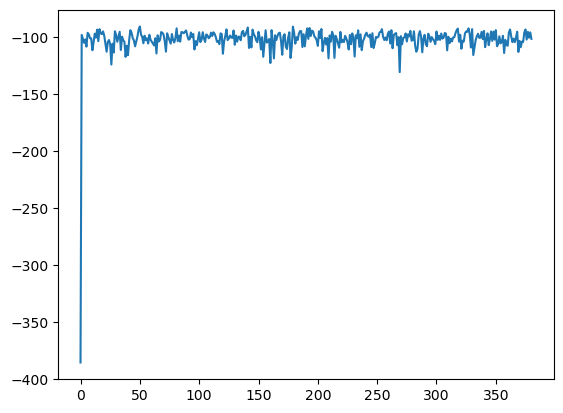